In [1]:
# Init
import glob
import os
import pickle
import re
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import altair as alt
from numpy import concatenate as c
from numpy import cumsum

alt.data_transformers.disable_max_rows()
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [21]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst):
    return lst[3000]


def returnMax(series):
    return max(series)


def returnList(HGTGen, lst):
    return lst[HGTGen]


def colorRanges(i):
    if i == 0:
        return "0"
    elif i > 0 and i <= 50:
        return "1-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


def extractDelim(names, delim):
    result = []
    for i in names:
        result.append(int(i.split(delim)[1].split(delim)[0]))
    return result


def zeroDivision(n, d):
    return n / d if d else maxVal


def dfWrangler(dataFrame):
    # Perform some data wrangling
    dataFrame[["TE_1_CN", "TE_2_CN"]] = dataFrame["TEfamilyCN"].apply(pd.Series)
    dataFrame[["TE_1_RG", "TE_2_RG"]] = dataFrame["TEfamilyRg"].apply(pd.Series)
    dataFrame[["TE_1_pi", "TE_2_pi"]] = dataFrame["TEpi"].apply(pd.Series)

    # Add column for max alpha and beta
    dataFrame["Max α"] = dataFrame["TE_1_CN"].apply(lambda x: returnMax(x))
    dataFrame["Max β"] = dataFrame["TE_2_CN"].apply(lambda x: returnMax(x))
    dataFrame["Max α/β"] = np.log(dataFrame["Max α"] / dataFrame["Max β"])

    return dataFrame


def dfReader(resultDir, suffix):
    # Read the json files into pandas dataframe
    SimulationRecords = []
    filenames = []
    for filename in glob.glob(os.path.join(resultDir, suffix)):
        filenames.append(filename)
        with open(filename, "r") as file:
            SimulationRecords.append(json.load(file))

    SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

    # Create a copy for inplace handling
    resultDataframe = SimulationResultsDataFrame.copy(deep=True)
    resultDataframe = dfWrangler(resultDataframe)
    return (resultDataframe, filenames)


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir, check=True):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        # Check if json conversion already exists
        if check == True:
            if os.path.isfile(file + ".json"):
                continue
        with open(file, "rb") as f:
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["AvgFit"]
            del data["Freq"]
            del data["TRate"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0


def TECNplot(df, ax, legend=True):
    resultDFT1 = pd.DataFrame(data=np.array(df["TE_1_CN"].tolist()))
    resultDFT1exp = list(resultDFT1.mean())
    resultDFT1mdn = list(resultDFT1.median())
    resultDFT1std = list(resultDFT1.std())

    resultDFT2 = pd.DataFrame(data=np.array(df["TE_2_CN"].tolist()))
    resultDFT2exp = list(resultDFT2.mean())
    resultDFT2mdn = list(resultDFT2.median())
    resultDFT2std = list(resultDFT2.std())

    # Meld for long form
    nameColumn = ["TE α"] * len(resultDFT1exp) + ["TE β"] * len(resultDFT2exp)
    exp = resultDFT1exp + resultDFT2exp
    mdn = resultDFT1mdn + resultDFT2mdn
    std = resultDFT1std + resultDFT2std
    generation = list(range(len(resultDFT1exp))) + list(range(len(resultDFT2exp)))
    plotDF = pd.DataFrame(
        {
            "TE": nameColumn,
            "Mean": exp,
            "Median": mdn,
            "std": std,
            "Generation": generation,
        }
    )
    plotDF["Mean"].replace(0, np.nan, inplace=True)
    sns.lineplot(
        data=plotDF,
        x="Generation",
        y="Mean",
        style="TE",
        hue="TE",
        ax=ax,
        legend=legend,
    )
    sns.scatterplot(
        x="Generation",
        y="Mean",
        ax=ax,
        style="TE",
        hue="TE",
        data=plotDF.loc[np.random.choice(plotDF.index, 100, replace=False)],
        legend=False,
        style_order=["TE α", "TE β"],
        hue_order=["TE α", "TE β"],
    )


# Functions for plotting rolling average of TE copy number vs Epi/CrossCoifdef
def plotLine(axis, x, y, color="b", linestyle="-"):
    axis.plot(x, y, c=color, linestyle=linestyle, alpha=0.7)


def PlotSample(axis, dataFrame, X, linestyle, plotTE="Both", discrete=False,):
    resultFrame = pd.DataFrame(
        {
            "Max α": dataFrame["Max α"].tolist(),
            "Max β": dataFrame["Max β"].tolist(),
            X: dataFrame[X].tolist(),
        }
    )
    resultFrame = resultFrame.sort_values(X)
    if discrete == False:
        resultFrame["Max α"] = resultFrame["Max α"].rolling(20).mean()
        resultFrame["Max β"] = resultFrame["Max β"].rolling(20).mean()
        resultFrame[X] = resultFrame[X].rolling(20).mean()
        #resultFrame["Max α"] = resultFrame["Max α"]
        #resultFrame["Max β"] = resultFrame["Max β"]
    else:
        groupingDict = {"Max α": "Max α", "Max β": "Max β"}
        resultFrame = (
            resultFrame.groupby(X, as_index=False)
            .agg({"Max α": "mean", "Max β": "mean"})
            .rename(columns=groupingDict)
        )
    # Generate result dataframe for plotting
    if plotTE == "Both":
        plotLine(
            axis,
            resultFrame[X].tolist(),
            resultFrame["Max α"].tolist(),
            color=linestyle,
            linestyle="-",
        )
        plotLine(
            axis,
            resultFrame[X].tolist(),
            resultFrame["Max β"].tolist(),
            color=linestyle,
            linestyle="-.",
        )
    else:
        plotLine(
            axis,
            resultFrame[X].tolist(),
            resultFrame["Max α"].tolist(),
            color="black",
            linestyle="-",
        )

In [3]:
# Path to results
resultDirectory = "./Results"

# Convert them to json
returnValue = pickleToJson(resultDirectory, check=True)

In [12]:
# Path to results
resultDirectory = "./Results"

# Generations
SimulationGenerations = [0, 300]

# Simulation cats
SimulationTypes = {
    "CoRegulation_Only": "_1",
    "Epistasis_Only": "_2",
    "Site_Only":"_3",
}

# Sub catagories 
SimulationSubTypes = [
    "2_TE_",
    "1_TE_"
]
# Simulation cats
#SimulationTypes = {
#    "2_TE_CoRegulation_Only": "_1",
#    "2_TE_Epistasis_Only": "_2",
#    "2_TE_Site_Only":"_3",
#    "1_TE_CoRegulation_Only": "_4",
#    "1_TE_Epistasis_Only": "_5",
#    "1_TE_Site_Only": "_6",
#}

# Convert them to json
returnValue = pickleToJson(resultDirectory, check=True)

# Dictionary of result dataframes
resultDataframe = {}

# Manually assigning data
resultDataframeCoRegulation, fileNames = dfReader(resultDirectory, "*" + "_1" + ".pickle.json")
insertionSites = extractDelim(fileNames, "-")
resultDataframeCoRegulation["Insertion Sites"] = insertionSites

DualTEFrameFrame = resultDataframeCoRegulation[resultDataframeCoRegulation["Max β"]!=0]
DualTEFrameGen0 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==0]
DualTEFrameGen300 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==300]

SingleTEFrame = resultDataframeCoRegulation[resultDataframeCoRegulation["Max β"]==0]
SingleTEFrameGen0 = SingleTEFrame[SingleTEFrame["HGTGen"]==0]
SingleTEFrameGen300 = SingleTEFrame[SingleTEFrame["HGTGen"]==300]

# Average the value of single TEs
SingleTEFrameGen0["Max α"] = SingleTEFrameGen0["Max α"].mean()
SingleTEFrameGen300["Max α"] = SingleTEFrameGen0["Max α"].mean()

resultDataframe[0,"1_TE_CoRegulation_Only"] = SingleTEFrameGen0
resultDataframe[300,"1_TE_CoRegulation_Only"] = SingleTEFrameGen0

resultDataframe[0,"2_TE_CoRegulation_Only"] = DualTEFrameGen0
resultDataframe[300,"2_TE_CoRegulation_Only"] = DualTEFrameGen300
# -------------------
resultDataframeEpistasis, fileNames = dfReader(resultDirectory, "*" + "_2" + ".pickle.json")
insertionSites = extractDelim(fileNames, "-")
resultDataframeEpistasis["Insertion Sites"] = insertionSites

DualTEFrameFrame = resultDataframeEpistasis[resultDataframeEpistasis["Max β"]!=0]
DualTEFrameGen0 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==0]
DualTEFrameGen300 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==300]

SingleTEFrame = resultDataframeEpistasis[resultDataframeEpistasis["Max β"]==0]
SingleTEFrameGen0 = SingleTEFrame[SingleTEFrame["HGTGen"]==0]
SingleTEFrameGen300 = SingleTEFrame[SingleTEFrame["HGTGen"]==300]

resultDataframe[0,"1_TE_Epistasis_Only"] = SingleTEFrameGen0
resultDataframe[300,"1_TE_Epistasis_Only"] = SingleTEFrameGen0

resultDataframe[0,"2_TE_Epistasis_Only"] = DualTEFrameGen0
resultDataframe[300,"2_TE_Epistasis_Only"] = DualTEFrameGen300
# -------------------
resultDataframeSite, fileNames = dfReader(resultDirectory, "*" + "_3" + ".pickle.json")
insertionSites = extractDelim(fileNames, "-")
resultDataframeSite["Insertion Sites"] = insertionSites

DualTEFrameFrame = resultDataframeSite[resultDataframeSite["Max β"]!=0]
DualTEFrameGen0 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==0]
DualTEFrameGen300 = DualTEFrameFrame[DualTEFrameFrame["HGTGen"]==300]

SingleTEFrame = resultDataframeSite[resultDataframeSite["Max β"]==0]
SingleTEFrameGen0 = SingleTEFrame[SingleTEFrame["HGTGen"]==0]
SingleTEFrameGen300 = SingleTEFrame[SingleTEFrame["HGTGen"]==300]

resultDataframe[0,"1_TE_Site_Only"] = SingleTEFrameGen0
resultDataframe[300,"1_TE_Site_Only"] = SingleTEFrameGen0

resultDataframe[0,"2_TE_Site_Only"] = DualTEFrameGen0
resultDataframe[300,"2_TE_Site_Only"] = DualTEFrameGen300
# -------------------

#for generation in SimulationGenerations:
#    for key, value in SimulationTypes.items():
#        tempDataFrame, scratch = 
#        
# Read the results
#for key, value in resultDirectories.items():
#    for key_s, value_s in SimulationTypes.items():
#        resultDataframe[key, key_s], scratch = dfReader(
#            value, "*" + value_s + ".pickle.json"
#        )

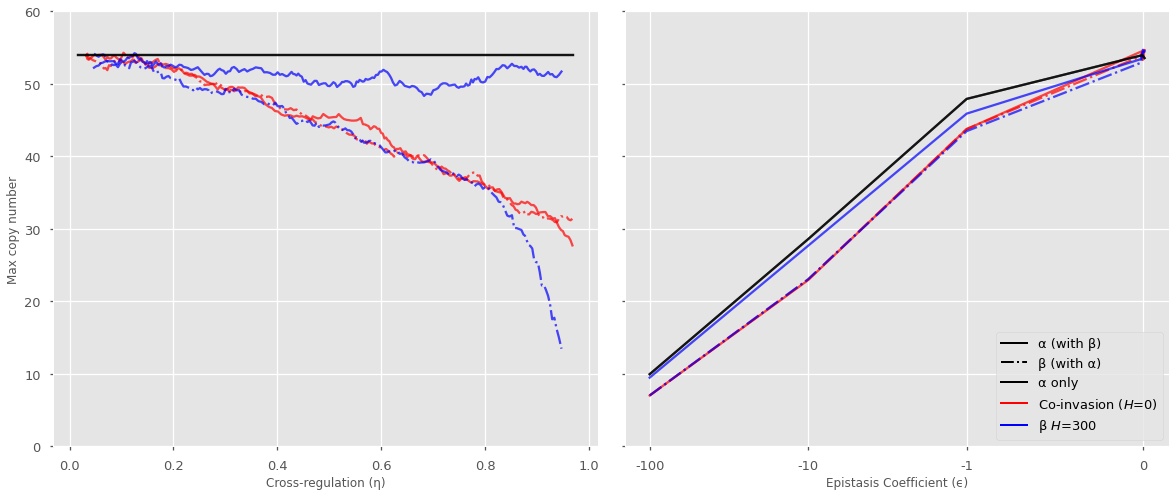

In [39]:
# Create plots

# Define style
plt.style.use("ggplot")

# Create base figure
fig, (ax1, ax2,) = plt.subplots(1, 2, sharey=True,)
fig.set_figheight(8)
fig.set_figwidth(20)

# Marker style for different generations
# markerDict = {0: "-", 300: "-.", 1000: ":"}
markerDict = {0: "r", 300: "b"}
# Type dict
plotTypes = {
    "2_TE_Epistasis_Only": "Both",
    "2_TE_CoRegulation_Only": "Both",
    "1_TE_Epistasis_Only": "Single",
    "1_TE_CoRegulation_Only": "Single",
}
axisTypes = {
    "2_TE_Epistasis_Only": ax2,
    "2_TE_CoRegulation_Only": ax1,
    "1_TE_Epistasis_Only": ax2,
    "1_TE_CoRegulation_Only": ax1,
}
labelTypes = {
    "2_TE_Epistasis_Only": "epistasisCoefficient",
    "2_TE_CoRegulation_Only": "ETA",
    "1_TE_Epistasis_Only": "epistasisCoefficient",
    "1_TE_CoRegulation_Only": "ETA",
}
discreteTypes = {
    "2_TE_Epistasis_Only": True,
    "2_TE_CoRegulation_Only": False,
    "1_TE_Epistasis_Only": True,
    "1_TE_CoRegulation_Only": False,
}

# Create plots
ax1.set_ylim(top=200)
for axisKey, axis in axisTypes.items():
    for MarkerKey, marker in markerDict.items():
        # print (MarkerKey, axisKey, axis, labelTypes[axisKey], marker, plotTypes[axisKey])
        PlotSample(
            axis,
            resultDataframe[MarkerKey, axisKey],
            labelTypes[axisKey],
            marker,
            plotTypes[axisKey],
            discrete = discreteTypes[axisKey]
        )

# Create labels
ax1.set_ylabel("Max copy number")
ax1.set_xlabel("Cross-regulation (η)")
ax2.set_xlabel("Epistasis Coefficient (ϵ)")
#ax3.set_xlabel("Number of insertion Sites")
# ax1.set_title("ax1 title")
# ax2.set_title("ax2 title")
ax2.set_xscale("symlog", linthresh=1)
# ax2.set_xscale("symlog")
# ax2.ticklabel_format(style='plain')
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax1.set_ylim([None,60])

# Draw legendbox
legend_elements = [Line2D([0], [0], color='black', linestyle='-', lw=2, label='α (with β)'),
                   Line2D([0], [0], color='black', linestyle='-.', lw=2, label='β (with α)'),
                   Line2D([0], [0], color='black', lw=2, label='α only'),
                   Line2D([0], [0], color='red', lw=2, label='Co-invasion ($H$=0)'),
                   Line2D([0], [0], color='blue', lw=2, label='β $H$=300'),]
ax2.legend(handles=legend_elements, loc='lower right')
# ax1.legend(handles=legend_elements, loc='lower left')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('Figure2.pdf', bbox_inches='tight')

In [ ]:
# Some extra steps for results from insertion site simulations
resultInsertionSites = "./InsertionSitesResults/"

# Convert to json
returnValue = pickleToJson(resultInsertionSites, check=True)

# Need to create condensed dataframe to add information about insertion sites
# and split them according to generation of transfer.
condensed, fileNames = dfReader(resultInsertionSites, "*" + "_0" + ".pickle.json")
# Extract insertion sites
insertionSites = extractDelim(fileNames, "-")
# Add this information to core dataFrame
condensed["Insertion Sites"] = insertionSites
# Split according to generation
for i in SimulationGenerations:
    resultDataframe[i, "2_TE_Site_Only"] = condensed[condensed["HGTGen"] == i]

# For single TE
condensed, fileNames = dfReader(resultInsertionSites, "*" + "_4" + ".pickle.json")
# Extract insertion sites
insertionSites = extractDelim(fileNames, "-")
# Add this information to core dataFrame
condensed["Insertion Sites"] = insertionSites
# Split according to generation
for i in SimulationGenerations:
    resultDataframe[i, "1_TE_Site_Only"] = condensed

In [20]:
style.available

In [29]:
from matplotlib.patches import Patch

In [11]:
SingleTEFrameGen0["Max α"].mean()

53.063068

In [38]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter